# Произведем импорт необходимых библиотек

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

# Загрузим датасеты, объединим по столбцу 'order_id' и изучим общую информацию

In [4]:
# Загрузка файлов CSV
plan_url = 'https://raw.githubusercontent.com/ivangor605/-DENIM/main/plan.csv'
payments_url = 'https://raw.githubusercontent.com/ivangor605/-DENIM/main/payments.csv'
orders_url = 'https://raw.githubusercontent.com/ivangor605/-DENIM/main/orders.csv'

# Чтение файлов в DataFrame
plan_df = pd.read_csv(plan_url)
payments_df = pd.read_csv(payments_url)
orders_df = pd.read_csv(orders_url)

# Объединение DataFrame по столбцу order_id
data = orders_df.merge(payments_df, on='order_id', how='left') \
                      .merge(plan_df, on='order_id', how='left')

In [5]:
# Вывод первых нескольких строк объединенного DataFrame
print("Объединенный DataFrame:")
display(data.head())

Объединенный DataFrame:


,order_id,created_at,put_at,closed_at,issued_sum,paid_at,paid_sum,plan_at,plan_sum_total
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:20:16.790,5600.0,2022-06-02,5600.0
1,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:20:16.790,5600.0,2022-07-02,9450.0
2,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:20:16.790,5600.0,2022-08-01,12170.0
3,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:20:16.790,5600.0,2022-08-31,14890.0
4,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:20:16.790,5600.0,2022-09-30,17610.0


In [6]:
data.describe()

,order_id,issued_sum,paid_sum,plan_sum_total
count,1.483588e+06,1.483588e+06,1.466216e+06,1.483588e+06
mean,4.472452e+08,9.253138e+03,3.320391e+03,9.426176e+03
std,2.742267e+07,5.185121e+03,4.161539e+03,8.252356e+03
min,4.000017e+08,1.000000e+03,2.000000e-02,0.000000e+00
25%,4.231932e+08,5.150000e+03,9.587000e+02,4.065460e+03
50%,4.471505e+08,8.740000e+03,1.790000e+03,7.773090e+03
75%,4.709684e+08,1.320000e+04,3.570000e+03,1.326760e+04
max,4.951775e+08,2.857000e+04,4.946937e+04,2.300000e+06


# Статистические характеристики:

Сумма выданных займов (issued_sum):

Среднее значение: 447,245,200 — это средняя сумма выданного займа.
Минимум и максимум: Минимальная сумма займа составляет 400,001,700, а максимальная — 495,177,500. Это говорит о значительном диапазоне в размерах займов.
Стандартное отклонение: 27,422,670 — это указывает на то, что суммы займов варьируются относительно среднего значения.

Сумма погашений (paid_sum):

Среднее значение: 9,253.14 — это средняя сумма погашения.
Минимум и максимум: Минимальная сумма погашения составляет 0.02 (что может указывать на случаи частичного погашения), а максимальная сумма — 28,570.00.
Стандартное отклонение: 5,185.12 — это также указывает на разброс в размерах погашений.

Запланированная сумма (plan_sum_total):

Среднее значение: 9,426.18.
Минимум и максимум: Минимальная запланированная сумма составляет 0.00 (что может указывать на отсутствие планов по погашению), а максимальная — 2,300,000.
Стандартное отклонение: 8,252.36 — это также указывает на разброс в запланированных суммах.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483588 entries, 0 to 1483587
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   order_id        1483588 non-null  int64  
 1   created_at      1483588 non-null  object 
 2   put_at          1483588 non-null  object 
 3   closed_at       1128774 non-null  object 
 4   issued_sum      1483588 non-null  float64
 5   paid_at         1466216 non-null  object 
 6   paid_sum        1466216 non-null  float64
 7   plan_at         1483588 non-null  object 
 8   plan_sum_total  1483588 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 101.9+ MB


В целом мы видим, что столбцы соответствуют своим типам данных. Есть пропуски в столбце "closed_at", думаю это связано с тем, что счета еще не закрыты. В столбцах "paid_sum" и "plan_at" есть пропуски, которые на мой взгляд возникли по причине, того что не были произведены оплаты на момент среза данных

## Создадим столбцы о наличии просрочки(по срокам) и по количеству дней в просрочке

In [11]:
# Преобразование строковых дат в datetime
data['plan_at'] = pd.to_datetime(data['plan_at'])
data['paid_at'] = pd.to_datetime(data['paid_at'])

# Создание столбца со сроком просрочки
# Если paid_at отсутствует (т.е. None), то считаем просрочку от plan_at до текущей даты
current_date = pd.to_datetime('2022-12-08')  # Укажите актуальную дату для анализа

data['overdue_days'] = (data['paid_at'].fillna(current_date) - data['plan_at']).dt.days

# Условие для определения просрочки: если срок больше 0, то это просрочка
data['is_overdue'] = data['overdue_days'] > 0


# Создадим столбцы с суммой недоплаты(денежной) и наличием недоплаты

In [13]:
# Создание нового столбца с суммой недоплаты
data['underpayment'] = data['plan_sum_total'] - data['paid_sum']

# Создание булевого столбца, показывающего наличие недоплаты
data['has_underpayment'] = data['underpayment'] > 0

# Вывод результата
data.head()

,order_id,created_at,put_at,closed_at,issued_sum,paid_at,paid_sum,plan_at,plan_sum_total,overdue_days,is_overdue,underpayment,has_underpayment
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:20:16.790,5600.0,2022-06-02,5600.0,0,False,0.0,False
1,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:20:16.790,5600.0,2022-07-02,9450.0,-30,False,3850.0,True
2,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:20:16.790,5600.0,2022-08-01,12170.0,-60,False,6570.0,True
3,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:20:16.790,5600.0,2022-08-31,14890.0,-90,False,9290.0,True
4,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0,2022-06-02 20:20:16.790,5600.0,2022-09-30,17610.0,-120,False,12010.0,True


# Установка ограничителя по датам

В ходе проекта выяснилось, что показаны данные по планируемым платежам вплоть по июль 23 года и что по ним присутствуют недоплаты. Однако не факт что будет недоплата на момент запланированной даты, ведь у клиентов еще есть время на погашение задолженностей. Поэтому вернувшись к началу проекта ограничим датасет строго до 8 декабря 2022 года.

In [15]:
# Убедитесь, что столбец 'plan_at' имеет тип datetime
data['plan_at'] = pd.to_datetime(data['plan_at'])

# Фильтрация данных до 8 декабря 2022 года
data = data[data['plan_at'] < '2022-12-08']

# Изучим доли просрочек (просрочки по времени и деньгам)

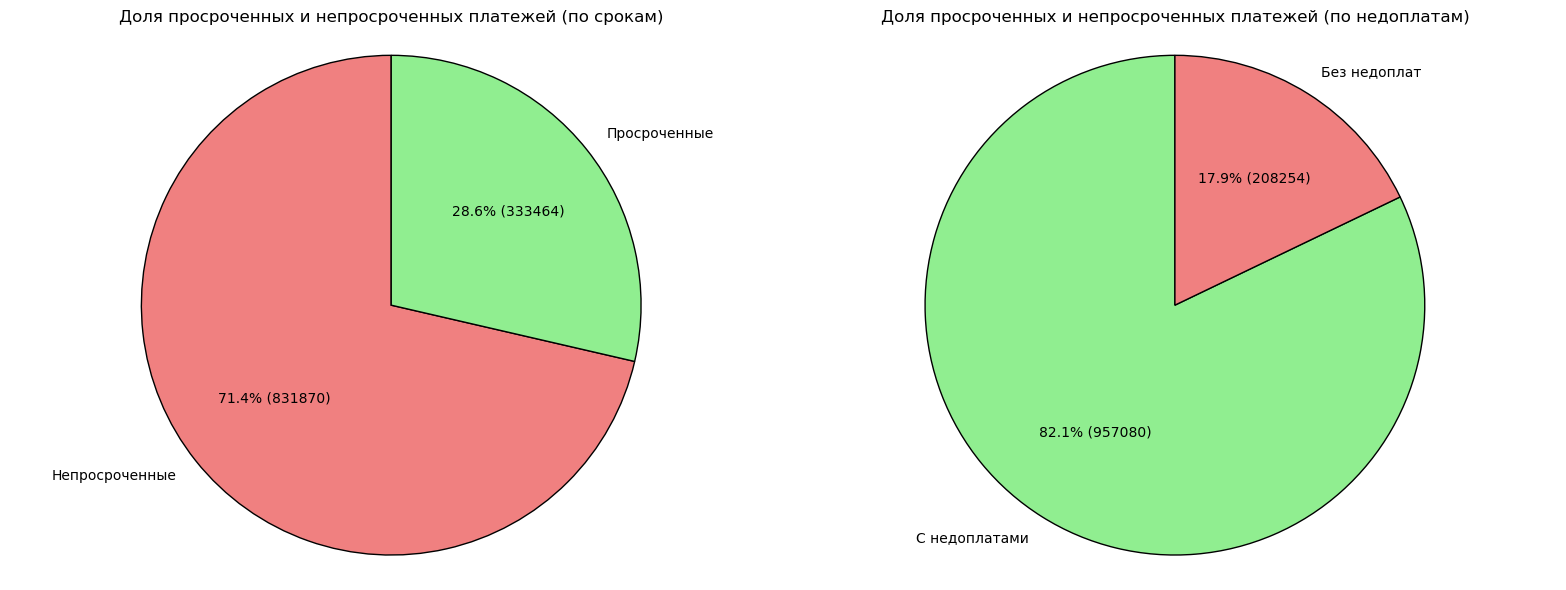

In [17]:
# Подсчет долей просроченных и непросроченных платежей
overdue_counts = data['is_overdue'].value_counts()
underpayment_counts = data['has_underpayment'].value_counts()

# Создание подграфиков
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

colors = ['lightcoral', 'lightgreen']

# Построение первой круговой диаграммы (по срокам)
axs[0].pie(overdue_counts,
           labels=overdue_counts.index.map({True: 'Просроченные', False: 'Непросроченные'}),
           autopct=lambda p: f'{p:.1f}% ({int(p * sum(overdue_counts) / 100)})',  # Процент и количество
           startangle=90,
           wedgeprops=dict(edgecolor='black'),
           colors=colors)

axs[0].set_title('Доля просроченных и непросроченных платежей (по срокам)')
axs[0].axis('equal')  # Чтобы круговая диаграмма была кругом

# Построение второй круговой диаграммы (по недоплатам)
colors = ['lightgreen', 'lightcoral']

axs[1].pie(underpayment_counts,
           labels=underpayment_counts.index.map({True: 'С недоплатами', False: 'Без недоплат'}),
           autopct=lambda p: f'{p:.1f}% ({int(p * sum(underpayment_counts) / 100)})',  # Процент и количество
           startangle=90,
           wedgeprops=dict(edgecolor='black'),  # Черная окантовка секторов
           colors=colors)  # Указание цветов

axs[1].set_title('Доля просроченных и непросроченных платежей (по недоплатам)')
axs[1].axis('equal')  

plt.tight_layout()  
plt.show()

Среди просрочек по срокам 28,6% просрочены по срокам и 82,1% по недоплатам по наличию недоплат. Это крайне критичный показатель, ведь 82,1% платежей не выплачиваются полностью согласно требованиям банка.

# Разделим платежи на 4 категории и посмотрим на их распределение

#### Категории:    

- 'Просроченные с недоплатами'
- 'Просроченные без недоплат'
- 'Непросроченные с недоплатами'
- 'Непросроченные без недоплат'

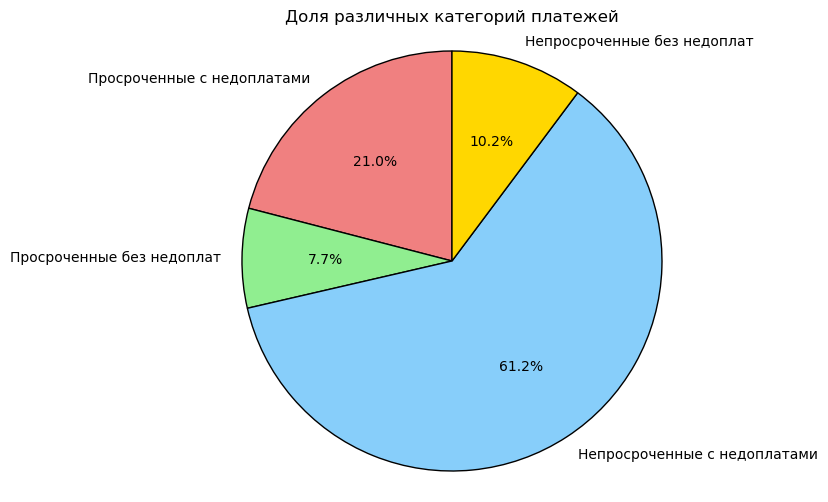

In [20]:
# Подсчет количества случаев для каждой категории
count_overdue_with_underpayment = data[(data['is_overdue'] == True) & (data['has_underpayment'] == True)].shape[0]
count_overdue_without_underpayment = data[(data['is_overdue'] == True) & (data['has_underpayment'] == False)].shape[0]
count_non_overdue_with_underpayment = data[(data['is_overdue'] == False) & (data['has_underpayment'] == True)].shape[0]
count_non_overdue_without_underpayment = data[(data['is_overdue'] == False) & (data['has_underpayment'] == False)].shape[0]

# Данные для круговой диаграммы
sizes = [
    count_overdue_with_underpayment,
    count_overdue_without_underpayment,
    count_non_overdue_with_underpayment,
    count_non_overdue_without_underpayment
]

labels = [
    'Просроченные с недоплатами',
    'Просроченные без недоплат',
    'Непросроченные с недоплатами',
    'Непросроченные без недоплат'
]

# Подсчет общего количества
total_count = sum(sizes)

# Создание таблицы с данными
table_data = {
    'Категория': labels,
    'Количество': sizes,
    'Процент': [f'{(size / total_count) * 100:.1f}%' for size in sizes]
}

table_df = pd.DataFrame(table_data)

# Построение круговой диаграммы
plt.figure(figsize=(8, 6))
plt.pie(sizes,
        labels=labels,
        autopct='%1.1f%%',  # Оставляем только процент
        startangle=90,
        wedgeprops=dict(edgecolor='black'),  # Черная окантовка секторов
        colors=['lightcoral', 'lightgreen', 'lightskyblue', 'gold'])  # Цвета для каждого сектора

plt.title('Доля различных категорий платежей')
plt.axis('equal')  # Чтобы круговая диаграмма была кругом

# Отображение круговой диаграммы
plt.show()

In [21]:
# Вывод таблицы с данными
print(table_df)

                      Категория  Количество Процент
0    Просроченные с недоплатами      244231   21.0%
1     Просроченные без недоплат       89233    7.7%
2  Непросроченные с недоплатами      712849   61.2%
3   Непросроченные без недоплат      119021   10.2%


### Вывод по категориям задолженности

Данные о задолженности заемщиков показывают следующие результаты:

1. **Просроченные с недоплатами (21%)**: Эта категория составляет значительную долю, указывая на то, что многие заемщики не только просрочили свои платежи, но и не выполнили их в полном объеме.

2. **Просроченные без недоплат (7.7%)**: Эта группа меньше по количеству, что может свидетельствовать о том, что некоторые заемщики полностью прекратили выплаты.

3. **Непросроченные с недоплатами (61.2%)**: Наибольшая доля заемщиков находится в этой категории, что указывает на то, что большинство заемщиков не успевают выполнять свои обязательства в срок, но продолжают делать частичные платежи.

4. **Непросроченные без недоплат (10.2%)**: Эта категория включает заемщиков, которые не имеют просрочек и полностью выполняют свои обязательства.

### Общий вывод

Наиболее тревожной является высокая доля неплатежей среди непросроченных займов (61.2%), что может указывать на потенциальные риски для кредиторов. Важно обратить внимание на стратегии управления рисками и улучшение финансовой грамотности заемщиков для снижения уровня просрочек и недоплат.

# Изучим распределение наличия временных просрочек по месяцам

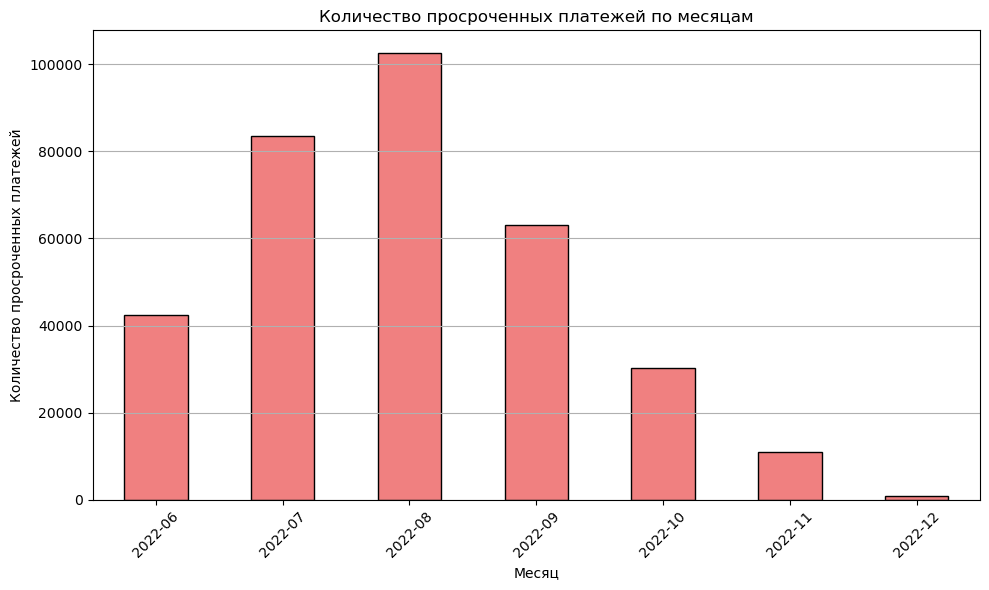

,plan_at,Количество просроченных платежей
0,2022-06,42326
1,2022-07,83421
2,2022-08,102637
3,2022-09,62965
4,2022-10,30355
5,2022-11,10944
6,2022-12,816


In [24]:
# Группировка данных по дате и подсчет количества просроченных платежей
overdue_counts = data[data['is_overdue'] == True].groupby(data['plan_at'].dt.to_period('M')).size()

# Вывод таблицы с количеством просроченных платежей
overdue_counts_df = overdue_counts.reset_index(name='Количество просроченных платежей')


# Построение графика
plt.figure(figsize=(10, 6))
overdue_counts.plot(kind='bar', color='lightcoral', edgecolor='black')  # Добавлена окантовка
plt.title('Количество просроченных платежей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество просроченных платежей')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Отображение графика
plt.tight_layout()
plt.show()
# Вывод таблицы с количеством просроченных платежей
overdue_counts_df = overdue_counts.reset_index(name='Количество просроченных платежей')
display(overdue_counts_df)

На основе полученных данных о количестве просроченных платежей по месяцам можно сделать следующие выводы:

1. **Общий тренд**: В течение рассматриваемого периода наблюдается значительное количество просроченных платежей, особенно в летние месяцы 2022 года. Это может указывать на сезонные колебания в финансовом поведении клиентов или на экономические факторы, влияющие на способность клиентов выполнять свои обязательства.

2. **Пик просрочек**: Наибольшее количество просроченных платежей зафиксировано в августе 2022 года (102637), что может быть связано с определенными экономическими условиями или изменениями в политике кредитования. Это требует дополнительного анализа для понимания причин такого роста.

3. **Снижение просрочек**: Начиная с сентября 2022 года, наблюдается заметное снижение количества просроченных платежей, что может свидетельствовать о том, что клиенты начали лучше справляться с финансовыми обязательствами или о том, что были предприняты меры по улучшению взыскания долгов.

4. **Низкие значения в конце года**: В декабре 2022 года количество просроченных платежей значительно снизилось до 816. Но это некорректно учитывать в анализе так как данные за декабрь неполные, а лишь только до 8 декабря.


В целом, результаты показывают важность мониторинга и анализа данных о просроченных платежах для принятия обоснованных решений в области управления рисками и кредитной политики.

# Изучим наличие денежных просрочек по месяцам

Предварительно изучив данные было видно, что показаны данные по планируемым платежам вплоть по июль 23 года и что по ним присутствуют недоплаты. Однако не факт что будет недоплата на момент запланированной даты, ведь у клиентов еще есть время на погашение задолженностей. Поэтому вернувшись к началу проекта ограничим датасет строго до 8 декабря 2022 года.

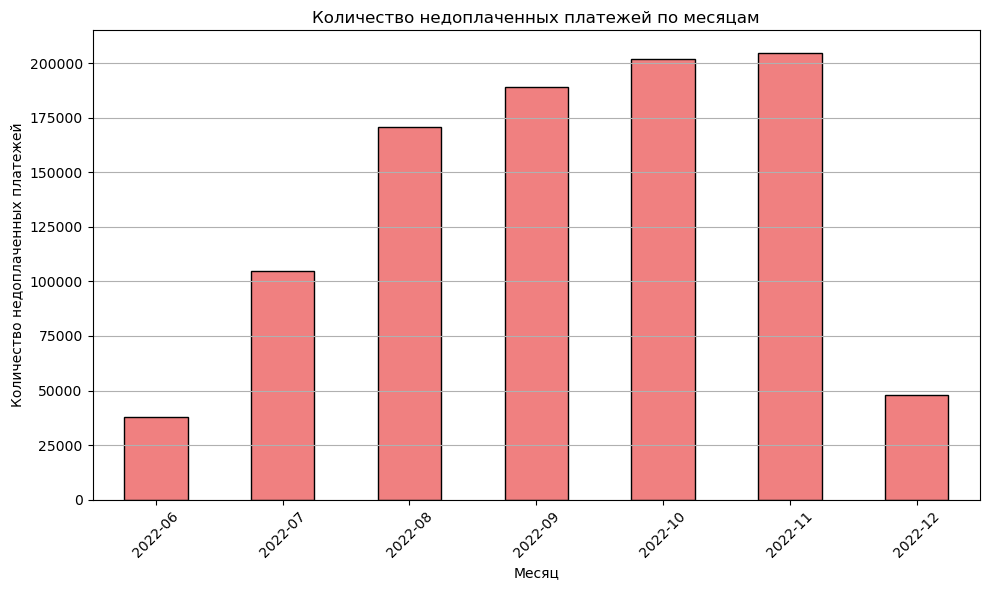

,plan_at,Количество недоплаченных платежей
0,2022-06,37847
1,2022-07,104913
2,2022-08,170693
3,2022-09,188832
4,2022-10,201932
5,2022-11,204746
6,2022-12,48117


In [28]:
# Группировка данных по дате и подсчет количества просроченных платежей
overdue_counts = data[data['has_underpayment'] == True].groupby(data['plan_at'].dt.to_period('M')).size()

# Построение графика
plt.figure(figsize=(10, 6))
overdue_counts.plot(kind='bar', color='lightcoral', edgecolor='black')  # Добавлена окантовка
plt.title('Количество недоплаченных платежей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество недоплаченных платежей')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Отображение графика
plt.tight_layout()
plt.show()

# Вывод таблицы с количеством просроченных платежей
overdue_counts_df = overdue_counts.reset_index(name='Количество недоплаченных платежей')
display(overdue_counts_df)

На основе полученных данных о количестве недоплаченных платежей по месяцам можно сделать следующие выводы:

1. **Общий тренд**: В течение рассматриваемого периода наблюдается значительное количество недоплаченных платежей, с явным увеличением их числа с июня по ноябрь 2022 года. Это может указывать на проблемы с финансовой дисциплиной клиентов или на экономические трудности, которые мешают им выполнять свои обязательства в полном объеме.

2. **Пик недоплат**: Наибольшее количество недоплаченных платежей зафиксировано в ноябре 2022 года (204746). Это может быть связано с различными факторами, такими как сезонные расходы, изменения в доходах клиентов или недостаточная финансовая грамотность.

3. **Снижение в декабре**: В декабре 2022 года количество недоплаченных платежей значительно снизилось до 54610. Однако это тоже некорректно учитывать в анализе в связи с тем, что данные предоставлены до 8 декабря

4. **Постоянный рост**: С июня по октябрь наблюдается устойчивый рост количества недоплаченных платежей, что может сигнализировать о необходимости пересмотра кредитной политики и внедрения более эффективных мер по управлению рисками.

# Посмотрим на динамику изменения денежной массы в просрочке

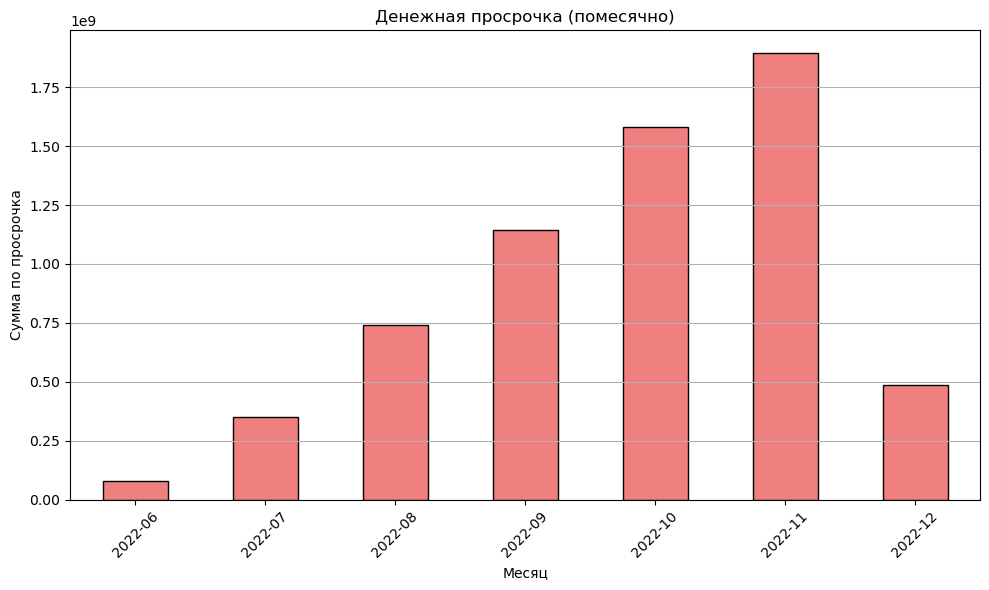

,plan_at,Cумма недоплаченных платежей
0,2022-06,7.879929e+07
1,2022-07,3.516911e+08
2,2022-08,7.422458e+08
3,2022-09,1.145062e+09
4,2022-10,1.579562e+09
5,2022-11,1.896032e+09
6,2022-12,4.868445e+08


In [31]:
# Группировка данных по дате и подсчет суммы по просрочке
monthly_underpayment = data[data['has_underpayment'] == True].groupby(data['plan_at'].dt.to_period('M'))['underpayment'].sum()

# Построение графика
plt.figure(figsize=(10, 6))
monthly_underpayment.plot(kind='bar', color='lightcoral', edgecolor='black')  # Добавлена окантовка
plt.title('Денежная просрочка (помесячно)')
plt.xlabel('Месяц')
plt.ylabel('Сумма по просрочка')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Отображение графика
plt.tight_layout()
plt.show()

# Вывод таблицы с количеством просроченных платежей
overdue_counts_df = monthly_underpayment.reset_index(name='Cумма недоплаченных платежей')
display(overdue_counts_df)

За рассматриваемый период (с июня по ноябрь) наблюдается более чем двадцатикратное увеличение суммы недоплаченных платежей. Что является крайне негативным трендом. Декабрь мы не учитываем в связи с тем, что данные представлены только до 8 декабря.

In [33]:
cutoff_date = pd.Timestamp('2022-11-30')
filtered_data = data[data['plan_at'] <= cutoff_date]

# Группировка данных по дате и подсчет суммы по просрочке и выданным займам
monthly_underpayment = filtered_data[filtered_data['has_underpayment'] == True].groupby(filtered_data['plan_at'].dt.to_period('M'))['underpayment'].sum()
monthly_issued_sum = filtered_data.groupby(filtered_data['plan_at'].dt.to_period('M'))['issued_sum'].sum()

# Создание DataFrame для вывода данных
summary_table = pd.DataFrame({
    'Сумма по просрочке': monthly_underpayment,
    'Сумма выданных займов': monthly_issued_sum
}).fillna(0)  # Заполнение NaN значений нулями

# Добавление третьего столбца с процентным соотношением
summary_table['Процент по просрочке'] = (summary_table['Сумма по просрочке'] / summary_table['Сумма выданных займов']) * 100

# Округление всех значений до двух знаков после запятой
summary_table = summary_table.round(2)

# Отображение итоговой таблицы
display(summary_table)

,Сумма по просрочке,Сумма выданных займов,Процент по просрочке
plan_at,,,
2022-06,7.879929e+07,5.448077e+08,14.46
2022-07,3.516911e+08,1.336898e+09,26.31
2022-08,7.422458e+08,2.072662e+09,35.81
2022-09,1.145062e+09,2.116365e+09,54.11
2022-10,1.579562e+09,2.145725e+09,73.61
2022-11,1.896032e+09,2.074881e+09,91.38


На основе предоставленных данных о сумме просроченных платежей и сумме выданных займов за период с июня по декабрь 2022 года можно провести анализ и сравнение этих двух показателей. 

### Общий анализ данных

1. **Сумма просрочки**:
   - Сумма просроченных платежей значительно увеличивается с июня по ноябрь, достигая пика в ноябре (1.896032e+09). В декабре наблюдается резкое снижение до 5.527323e+08, но это связано с ограниченностью датасета.

2. **Сумма выданных займов**:
   - Сумма выданных займов также демонстрирует рост с июня по ноябрь, достигая максимума в октябре (2.145725e+09). В декабре сумма выданных займов значительно снижается до 5.448077e+08, что может быть связано с окончанием отчетного периода или изменением в кредитной политике.

### Сравнение суммы просрочки и суммы выданных займов

Для более глубокого анализа можно рассмотреть соотношение между суммой просроченных платежей и суммой выданных займов:

- **Июнь**:  14.4%

- **Июль**: 26.3%

- **Август**: 35.8%

- **Сентябрь**: 54.1%

- **Октябрь**: 73.6%

- **Ноябрь**: 91.4%

### Выводы

1. **Тенденция роста просрочки**:
   - Наблюдается значительный рост суммы просроченных платежей по сравнению с суммой выданных займов в течение рассматриваемого периода, особенно в октябре и ноябре.

2. **Необходимость анализа причин**:
   - Рекомендуется провести более глубокий анализ причин роста просроченной задолженности, включая возможные изменения в экономической ситуации, кредитной политике или уровне доходов заемщиков.

3. **Рекомендации по управлению рисками**:
   - Необходимо разработать стратегии управления рисками для снижения уровня просроченной задолженности, такие как улучшение процесса оценки кредитоспособности заемщиков и внедрение программ по работе с должниками.

Таким образом, данные показывают необходимость внимательного мониторинга ситуации и принятия мер для предотвращения дальнейшего ухудшения финансовых показателей компании.

In [35]:
cutoff_date = pd.Timestamp('2022-11-30')
filtered_data = data[data['plan_at'] <= cutoff_date]


# Подготовка данных
filtered_data['month'] = filtered_data['plan_at'].dt.month
filtered_data['year'] = filtered_data['plan_at'].dt.year

# Группировка данных по месяцам
monthly_data = filtered_data.groupby(['year', 'month']).agg({
    'underpayment': 'sum',
    'issued_sum': 'sum'
}).reset_index()

# Создание признаков для модели
monthly_data['previous_underpayment'] = monthly_data['underpayment'].shift(1)
monthly_data['previous_issued_sum'] = monthly_data['issued_sum'].shift(1)

# Удаление NaN значений (первый месяц будет NaN)
monthly_data.dropna(inplace=True)

# Определение признаков и целевых переменных
X = monthly_data[['previous_underpayment', 'previous_issued_sum']]
y_underpayment = monthly_data['underpayment']
y_issued_sum = monthly_data['issued_sum']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train_underpayment, y_test_underpayment = train_test_split(X, y_underpayment, test_size=0.2, random_state=42)
X_train_issued, X_test_issued, y_train_issued, y_test_issued = train_test_split(X, y_issued_sum, test_size=0.2, random_state=42)

# Обучение модели для предсказания просрочки
model_underpayment = RandomForestRegressor(random_state=42)
model_underpayment.fit(X_train, y_train_underpayment)

# Обучение модели для предсказания выданных займов
model_issued_sum = RandomForestRegressor(random_state=42)
model_issued_sum.fit(X_train_issued, y_train_issued)

# Предсказание значений на декабрь 2022 года (используем последние значения)
last_row = monthly_data.iloc[-1]
X_december = pd.DataFrame({
    'previous_underpayment': [last_row['underpayment']],
    'previous_issued_sum': [last_row['issued_sum']]
})
predicted_underpayment_december = round((model_underpayment.predict(X_december)[0]))
predicted_issued_sum_december = model_issued_sum.predict(X_december)[0]


/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_76965/2964472067.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['month'] = filtered_data['plan_at'].dt.month
/var/folders/_x/cbc1r7kn2qlbny694ldlxkf40000gn/T/ipykernel_76965/2964472067.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['year'] = filtered_data['plan_at'].dt.year


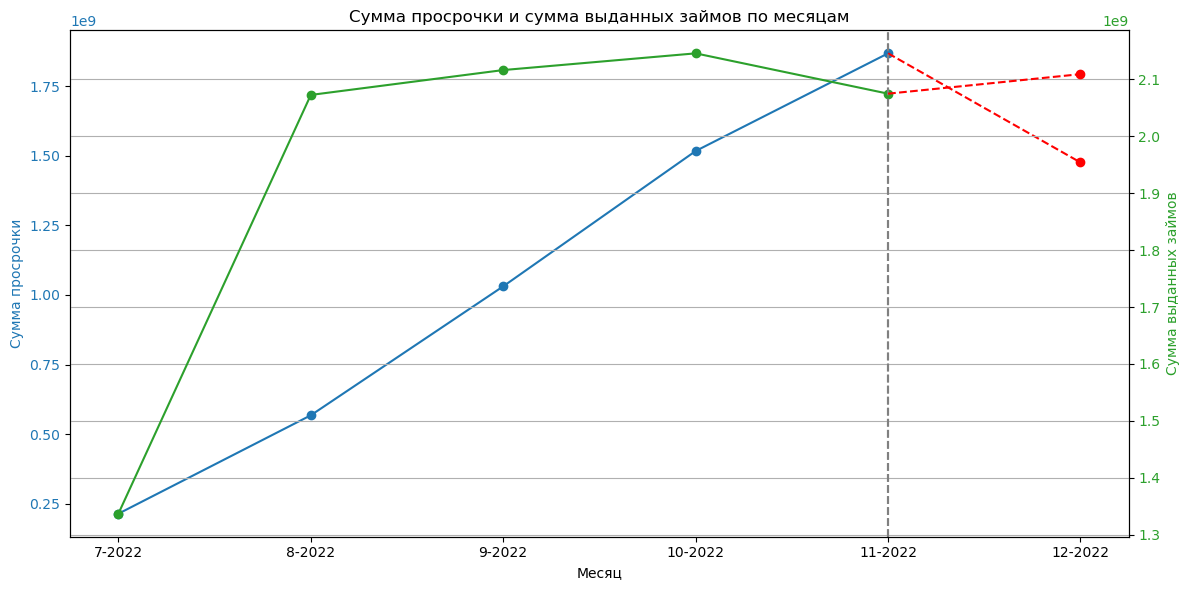

'Предсказанная сумма просрочки в декабре 2022 года: 1476032647'

'Предсказанная сумма выданных займов в декабре 2022 года: 2109166699.2'

In [36]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# График для суммы просрочки
color = 'tab:blue'
ax1.set_xlabel('Месяц')
ax1.set_ylabel('Сумма просрочки', color=color)
ax1.plot(monthly_data['month'].astype(str) + '-' + monthly_data['year'].astype(str), 
         monthly_data['underpayment'], marker='o', label='Сумма просрочки', color=color)
ax1.scatter(['12-2022'], [predicted_underpayment_december], color='red', label='Предсказанная просрочка (декабрь 2022)', zorder=5)
ax1.axvline(x=monthly_data['month'].astype(str).iloc[-1] + '-' + str(monthly_data['year'].iloc[-1]), color='gray', linestyle='--')
ax1.plot([monthly_data['month'].astype(str).iloc[-1] + '-' + str(monthly_data['year'].iloc[-1]), '12-2022'], 
         [monthly_data['underpayment'].iloc[-1], predicted_underpayment_december], color='red', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

# Создание второй оси для суммы выданных займов
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Сумма выданных займов', color=color)
ax2.plot(monthly_data['month'].astype(str) + '-' + monthly_data['year'].astype(str), 
         monthly_data['issued_sum'], marker='o', label='Сумма выданных займов', color=color)
ax2.scatter(['12-2022'], [predicted_issued_sum_december], color='red', label='Предсказанная сумма (декабрь 2022)', zorder=5)
ax2.axvline(x=monthly_data['month'].astype(str).iloc[-1] + '-' + str(monthly_data['year'].iloc[-1]), color='gray', linestyle='--')
ax2.plot([monthly_data['month'].astype(str).iloc[-1] + '-' + str(monthly_data['year'].iloc[-1]), '12-2022'], 
         [monthly_data['issued_sum'].iloc[-1], predicted_issued_sum_december], color='red', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Добавление заголовка и легенды
plt.title('Сумма просрочки и сумма выданных займов по месяцам')
fig.tight_layout()  
plt.grid(axis='y')
plt.show()

display(f"Предсказанная сумма просрочки в декабре 2022 года: {predicted_underpayment_december}")
display(f"Предсказанная сумма выданных займов в декабре 2022 года: {predicted_issued_sum_december}")

С помощью метода RandomForestRegressor было произведено машинное обучение и мы можем посмотреть каково будет возможным значение суммы просрочки и суммы займа за полный месяц в декабре 2022 года (напомню, что у нас были представлены данные лишь до 8 декабря). По полученным результатам видим, что сумма просрочек в декабре должна будет снизится и составит: 1476032647, а сумма выданных займов вырастет до значения 2109166699,2.

# Общий вывод о проделанной работе

В ходе анализа данных о задолженности заемщиков за период с июня по декабрь 2022 года были выявлены ключевые тенденции и проблемы, требующие внимания. Основные результаты и выводы можно обобщить следующим образом:

1. **Критическая ситуация с задолженностью**:
   - Высокий уровень просроченных платежей (28,6% по срокам) и значительная доля недоплат (82,1%) указывают на серьезные проблемы в финансовом поведении заемщиков. Это создает риски для кредиторов и требует немедленного вмешательства.

2. **Тенденции по просрочкам**:
   - Наблюдается значительный рост просроченных платежей, особенно в летние месяцы 2022 года, с пиком в августе. Сентябрь показал некоторое снижение, что может свидетельствовать о том, что заемщики начали лучше справляться с обязательствами или были предприняты меры по улучшению взыскания долгов.

3. **Недоплаты**:
   - Сумма недоплаченных платежей также демонстрирует устойчивый рост, достигая максимума в ноябре. Это подчеркивает необходимость пересмотра кредитной политики и внедрения более эффективных мер управления рисками.

4. **Сравнение суммы просрочки и суммы выданных займов**:
   - Соотношение между суммой просроченных платежей и суммой выданных займов показывает тревожную тенденцию роста, особенно в октябре и ноябре, что указывает на ухудшение финансового состояния заемщиков.

5. **Прогноз на декабрь**:
   - Применение метода RandomForestRegressor для прогнозирования показало, что сумма просрочек в декабре может снизиться до 1,476032647 миллиарда рублей, а сумма выданных займов вырастет до 2,109166699 миллиарда рублей. Это может свидетельствовать о возможном улучшении ситуации, однако необходимо учитывать неполноту данных за декабрь.

## Рекомендации

- **Глубокий анализ причин**: Рекомендуется провести детальный анализ факторов, способствующих росту задолженности, включая экономические условия и изменения в кредитной политике.
- **Управление рисками**: Разработка стратегий управления рисками для снижения уровня просроченной задолженности является приоритетной задачей.
- **Мониторинг и адаптация**: Необходимо регулярно отслеживать динамику задолженности и адаптировать кредитную политику в соответствии с изменениями на рынке.

Таким образом, проделанная работа подчеркивает важность мониторинга финансового состояния заемщиков и необходимости принятия проактивных мер для предотвращения дальнейшего ухудшения ситуации с задолженностью.